In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.cross_validation import train_test_split
import random
from sklearn.metrics import log_loss
from math import exp
import xgboost as xgb
from XGBoostPackage import xgbClass
from CrossValidation import CVScore
# from difflib import SequenceMatcher
import editdistance

%matplotlib inline

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
random.seed(321)
np.random.seed(321)

X_train = pd.read_json("../input/train.json")
X_test = pd.read_json("../input/test.json")

In [3]:
interest_level_map = {'low': 0, 'medium': 1, 'high': 2}
X_train['interest_level'] = X_train['interest_level'].apply(lambda x: interest_level_map[x])
X_test['interest_level'] = -1
X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))
X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.strip().lower().split(" ")) for i in x]))

In [4]:
def clean(x):
#     x = s.replace("-", "")
#     x = x.replace(" ", "")
#     x = x.replace("twenty_four_hour", "24")
#     x = x.replace("24/7", "24")
#     x = x.replace("24hr", "24")
#     x = x.replace("24-hour", "24")
#     x = x.replace("24hour", "24")
#     x = x.replace("24 hour", "24")
    for i in ['24-hour_doorman',
              '24/7_concierge',
              '24/7_doorman',
              '24/7_doorman_concierge',
              '24hr_doorman']+['24_hour_concierge/doorman', '24_hour_doorman']\
    +['twenty-four_hour_concierge_and_doorman'\
             ,'time_doorman','full-time_doorman','ft_doorman']:
        x = x.replace(i, '24hr_doorman')
    #x = x.replace("common", "cm")
    for i in ['cable/satellite_tv', 'cable_ready']:
        x = x.replace(i, 'cable')
    for i in ["children's_playroom",
#               'children\xe2\x80\x99s_playroom',
              'childrens_playroom']:
        x = x.replace(i, "children's_playroom")
    #x = x.replace("concierge", "doorman")
    #x = x.replace("bicycle", "bike")
    for i in ['bicycle_room', 'bike_room', 'bike_storage']:
        x = x.replace(i, 'bike_room')
    for i in ['billiards',
              'billiards_room',
              'billiards_table_and_wet_bar']:
        x = x.replace(i, 'billiards')
    for i in ['concierge', 'concierge_service', 'doorman', 'doorman_service'
             ]:
        x = x.replace(i, 'doorman')
    #x = x.replace("private", "pv")
    #x = x.replace("deco", "dc")
    #x = x.replace("decorative", "dc")
    x = x.replace('deco_brick_walls', 'deco_brick_wall')
    x = x.replace('deco_fireplace','decorative_fireplace')
    x = x.replace('dish_washer', 'dishwasher')
    #x = x.replace("onsite", "os")
    #x = x.replace("outdoor", "od")
    for i in ['fitness_center', 'fitness_facility', 'fitness_room']\
    +['gym/fitness','gym_in_building']:
        x = x.replace(i, 'gym')
    x = x.replace('fireplaces','fireplace')
    for i in ['eat-in_kitchen'\
             ,'in_kitchen_', 'in_kitchen']:
        x = x.replace(i,'eat_in_kitchen')
#     x = x.replace("ft","full-time")
    for i in ['granite_counter_tops',
              'granite_counters',
              'granite_countertops',
              'granite_kitchen']:
        x = x.replace(i, 'granite')
    for i in ['hardwood', 'hardwood_floor', 'hardwood_floors']:
        x = x.replace(i, 'harwood')
    x = x.replace('high_ceilings','high_ceiling')
    for i in ['high-speed_internet',
#               'high_floor',
#              'high_speed_internet',
              'high_speed_internet_available']:
#               'highrise']:
        x = x.replace(i, 'high_speed_internet')
    x = x.replace('large_living-room', 'large_living_room')
    x = x.replace('laundry_on_every_floor','laundry_on_floor')
    x = x.replace('marble_bathroom','marble_bath')
    x = x.replace('media_screening_room','media_room')
    x = x.replace('multi-level', 'multi_level')
    for i in ['parking',
              'parking_available',
              'parking_space']:
        x = x.replace(i, 'parking')
    for i in ['pets',
              'pets:_cats/small_dogs',
              'pets_allowed',
              'pets_on_approval']+['all_pets_ok','_pets_ok_','pet_friendly']:
        x = x.replace(i, 'pets')
    for i in ['pre_war']+['pre-war', 'prewar', 'pre']:
        x = x.replace(i, 'pre')
    for i in ['post-war', 'post_war', 'postwar', 'post']:
        x = x.replace(i, 'post')
    for i in ['roof',
              'roof-deck',
              'roof_access',
              'roof_deck',
              #'roof_deck_with_grills',
              'roof_decks',
              'roofdeck',
              'rooftop',
              'rooftop_deck',
              'rooftop_terrace', 'common_roof_deck','common_roof']:
        x = x.replace(i,'roof')
    x = x.replace('shares_ok','share_ok')
    for i in ["ss appliances", 'stainless_steel',
              'stainless_steel_appliances',
              'stainless_steel_kitchen']:
        x = x.replace(i, "stainless")
    for i in ['storage',
              'storage_available',
              'storage_facilities_available',
              'storage_room',
              'storage_space']:
        x = x.replace(i, 'storage')
    for i in ['super_on-site']+['live-in_super',
              'live-in_superintendent',
              'live/work',
              'live_in_super']:
        x = x.replace(i, 'super')
    x.replace('swimming_pool', 'pool')
    for i in ['valet',
              'valet_laundry',
#               'valet_parking',
              'valet_service',
              'valet_services',
              'valet_services_(housekeeping/dry_cleaning_available)',
              'valet_services_including_dry_cleaning','laundry_&_housekeeping']:
        x = x.replace(i, 'valet')
    for i in ['dryer_in_unit','washer/dryer_in-unit','washer_in_unit', 'laundry_in_unit']:
        x = x.replace(i,'washer_in_unit')    
    for i in ['walk-in_closet',
#               'walk-up',
#              'walk_in_closet',
              'walk_in_closet(s)',
              'closet_space'
             ]:
        x = x.replace(i, 'closet')
    for i in ['dry_cleaning_service',
              'washer/dryer_hookup',
              'washer/dryer_in_bldg',
              'washer/dryer_in_building',              
              'washer_&_dryer','laundry_in_building','laundry_room',
             'site_laundry']:
        x = x.replace(i, 'laundry')
    x = x.replace('wheelchair_ramp', 'wheelchair_access')
    return x

In [5]:
print(X_train.shape)
X_train['features']=X_train['features'].apply(clean)
X_test['features']=X_test['features'].apply(clean)
X_train.head(1)

(49352, 15)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,,1,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue


In [6]:
#add features
feature_transform = CountVectorizer(stop_words='english', max_features=150)
# X_train['features'] = X_train["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
# X_test['features'] = X_test["features"].apply(lambda x: " ".join(["_".join(i.lower().split(" ")) for i in x]))
feature_transform.fit(list(X_train['features']) + list(X_test['features']))

train_size = len(X_train)
low_count = len(X_train[X_train['interest_level'] == 0])
medium_count = len(X_train[X_train['interest_level'] == 1])
high_count = len(X_train[X_train['interest_level'] == 2])

In [7]:
def find_objects_with_only_one_record(feature_name):
    temp = pd.concat([X_train[feature_name].reset_index(), 
                      X_test[feature_name].reset_index()])
    temp = temp.groupby(feature_name, as_index = False).count()
    return temp[temp['index'] == 1]

managers_with_one_lot = find_objects_with_only_one_record('manager_id')
buildings_with_one_lot = find_objects_with_only_one_record('building_id')
addresses_with_one_lot = find_objects_with_only_one_record('display_address')


In [8]:
lambda_val = None
k=5.0
f=1.0
r_k=0.01 
g = 1.0
def categorical_average(variable, y, pred_0, feature_name):
    def calculate_average(sub1, sub2):
        s = pd.DataFrame(data = {
                                 variable: sub1.groupby(variable, as_index = False).count()[variable],                              
                                 'sumy': sub1.groupby(variable, as_index = False).sum()['y'],
                                 'avgY': sub1.groupby(variable, as_index = False).mean()['y'],
                                 'cnt': sub1.groupby(variable, as_index = False).count()['y']
                                 })
                                 
        tmp = sub2.merge(s.reset_index(), how='left', left_on=variable, right_on=variable) 
        del tmp['index']                       
        tmp.loc[pd.isnull(tmp['cnt']), 'cnt'] = 0.0
        tmp.loc[pd.isnull(tmp['cnt']), 'sumy'] = 0.0

        def compute_beta(row):
            cnt = row['cnt'] if row['cnt'] < 200 else float('inf')
            return 1.0 / (g + exp((cnt - k) / f))
            
        if lambda_val is not None:
            tmp['beta'] = lambda_val
        else:
            tmp['beta'] = tmp.apply(compute_beta, axis = 1)
            
        tmp['adj_avg'] = tmp.apply(lambda row: (1.0 - row['beta']) * row['avgY'] + row['beta'] * row['pred_0'],
                                   axis = 1)
                                   
        tmp.loc[pd.isnull(tmp['avgY']), 'avgY'] = tmp.loc[pd.isnull(tmp['avgY']), 'pred_0']
        tmp.loc[pd.isnull(tmp['adj_avg']), 'adj_avg'] = tmp.loc[pd.isnull(tmp['adj_avg']), 'pred_0']
        tmp['random'] = np.random.uniform(size = len(tmp))
        tmp['adj_avg'] = tmp.apply(lambda row: row['adj_avg'] *(1 + (row['random'] - 0.5) * r_k),
                                   axis = 1)
    
        return tmp['adj_avg'].ravel()
     
    #cv for training set 
    k_fold = StratifiedKFold(5)
    X_train[feature_name] = -999 
    for (train_index, cv_index) in k_fold.split(np.zeros(len(X_train)),
                                                X_train['interest_level'].ravel()):
        sub = pd.DataFrame(data = {variable: X_train[variable],
                                   'y': X_train[y],
                                   'pred_0': X_train[pred_0]})
            
        sub1 = sub.iloc[train_index]        
        sub2 = sub.iloc[cv_index]
        
        X_train.loc[cv_index, feature_name] = calculate_average(sub1, sub2)
    
    #for test set
    sub1 = pd.DataFrame(data = {variable: X_train[variable],
                                'y': X_train[y],
                                'pred_0': X_train[pred_0]})
    sub2 = pd.DataFrame(data = {variable: X_test[variable],
                                'y': X_test[y],
                                'pred_0': X_test[pred_0]})
    X_test.loc[:, feature_name] = calculate_average(sub1, sub2)                               



In [9]:
def transform_data(X):
    #add features    
    feat_sparse = feature_transform.transform(X["features"])
    vocabulary = feature_transform.vocabulary_
    del X['features']
    X1 = pd.DataFrame([ pd.Series(feat_sparse[i].toarray().ravel()) for i in np.arange(feat_sparse.shape[0]) ])
    X1.columns = list(sorted(vocabulary.keys()))
    X = pd.concat([X.reset_index(), X1.reset_index()], axis = 1)
    del X['index']
    
    X["num_photos"] = X["photos"].apply(len)
    X['created'] = pd.to_datetime(X["created"])
    X["num_description_words"] = X["description"].apply(lambda x: len(x.split(" ")))
    X['price_per_bed'] = X['price'] / X['bedrooms']    
    X['price_per_bath'] = X['price'] / X['bathrooms']
    X['price_per_room'] = X['price'] / (X['bathrooms'] + X['bedrooms'] )
    
    X['low'] = 0
    X.loc[X['interest_level'] == 0, 'low'] = 1
    X['medium'] = 0
    X.loc[X['interest_level'] == 1, 'medium'] = 1
    X['high'] = 0
    X.loc[X['interest_level'] == 2, 'high'] = 1
    
    X['display_address'] = X['display_address'].apply(lambda x: x.lower().strip())
    X['street_address'] = X['street_address'].apply(lambda x: x.lower().strip())
#     def similar(a, b):
#         return SequenceMatcher(None, a, b).ratio()
#     X['display_street_dist']=X.apply(lambda row: similar(row['display_address'], row['street_address']), axis=1)
    X['display_street_dist']=X.apply(lambda row: editdistance.eval\
                                     (row['display_address'], row['street_address']), axis=1)
    
    X['pred0_low'] = low_count * 1.0 / train_size
    X['pred0_medium'] = medium_count * 1.0 / train_size
    X['pred0_high'] = high_count * 1.0 / train_size
    
    X.loc[X['manager_id'].isin(managers_with_one_lot['manager_id'].ravel()), 
          'manager_id'] = "-1"
    X.loc[X['building_id'].isin(buildings_with_one_lot['building_id'].ravel()), 
          'building_id'] = "-1"
    X.loc[X['display_address'].isin(addresses_with_one_lot['display_address'].ravel()), 
          'display_address'] = "-1"
          
    return X

def normalize_high_cordiality_data():
    high_cardinality = ["building_id", "manager_id"]
    for c in high_cardinality:
        categorical_average(c, "medium", "pred0_medium", c + "_mean_medium")
        categorical_average(c, "high", "pred0_high", c + "_mean_high")

def transform_categorical_data():
    categorical = ['building_id', 'manager_id', 
                   'display_address', 'street_address']
                   
    for f in categorical:
        encoder = LabelEncoder()
        encoder.fit(list(X_train[f]) + list(X_test[f])) 
        X_train[f] = encoder.transform(X_train[f].ravel())
        X_test[f] = encoder.transform(X_test[f].ravel())
                  

def remove_columns(X):
    columns = ["photos", "pred0_high", "pred0_low", "pred0_medium",
               "description", "low", "medium", "high",
               "interest_level", "created"]
    for c in columns:
        del X[c]

In [10]:
print("Starting transformations")        
X_train = transform_data(X_train)    
X_test = transform_data(X_test) 
y_train = X_train['interest_level'].ravel()

print("Normalizing high cordiality data...")
normalize_high_cordiality_data()
transform_categorical_data()

remove_columns(X_train)
remove_columns(X_test)


Starting transformations
Normalizing high cordiality data...


In [11]:
print(X_train.shape)
X_train.head(2)

(49352, 170)


,bathrooms,bedrooms,building_id,display_address,latitude,listing_id,longitude,manager_id,price,street_address,...,num_photos,num_description_words,price_per_bed,price_per_bath,price_per_room,display_street_dist,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high
0,1.5,3,2103,10443,40.7145,7211212,-73.9425,1203,3000,21630,...,5,95,1000.0,2000.0,666.666667,4,0.217575,7.436940e-02,0.283585,9.190504e-29
1,1.0,2,5077,7525,40.7947,7150865,-73.9667,1518,5465,21801,...,11,9,2732.5,5465.0,1821.666667,4,0.110642,1.761506e-07,0.012447,2.088626e-34


In [12]:
featuresInUse = [f for f in X_train.columns if f not in ['manager_id', 'building_id', "display_address"]\
                  +['pre','war','eat']                                       
                ]
                                                        #,'no_pets','_pets_ok_','bedrooms', 'dryer_in_unit',
                                                        #'health_club','common', 
#                  +list(imp.sort_values("train").head(10).index)]
#featuresInUse = [f for f in X_train.columns if f not in []]
len(featuresInUse)

166

In [15]:
#cross validation

X_fit, X_val, y_fit, y_val=train_test_split(X_train[featuresInUse], y_train, test_size=0.33, random_state=42)

In [13]:
param = {}
param['objective'] = 'multi:softprob'
param['eta'] = 0.02
param['max_depth'] = 4
param['silent'] = 1
param['num_class'] = 3
param['eval_metric'] = "mlogloss"
param['min_child_weight'] = 1
param['subsample'] = 0.7
param['colsample_bytree'] = 0.7
param['seed'] = 321
param['nthread'] = 8
num_rounds = 2000


In [17]:
xgfit = xgb.DMatrix(X_fit, label=y_fit)
clfCV = xgb.train(param, xgfit, num_rounds)

xgval = xgb.DMatrix(X_val)
y_val_pred = clfCV.predict(xgval)
log_loss(y_val, y_val_pred)
#0.535112: 2000, f not in ['manager_id', 'building_id', "display_address"\,'common_roof_deck']]

0.53572128538904307

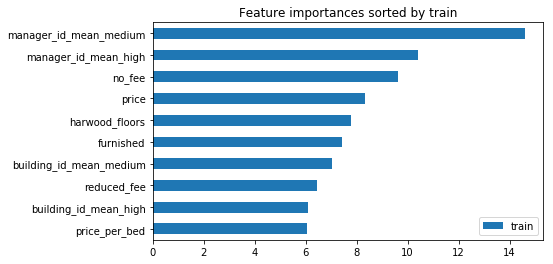

In [18]:
imp=pd.DataFrame()#(index=features_to_use)
imp['train'] = pd.Series(clfCV.get_score(importance_type='gain'))#, index=features_to_use)
imp = imp.fillna(0)
ax=imp.sort_values('train').tail(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [19]:
print(len(imp))
imp.sort_values('train',ascending=False).head(45)

129


,train
manager_id_mean_medium,14.591270
manager_id_mean_high,10.411911
no_fee,9.627497
price,8.351470
harwood_floors,7.775082
furnished,7.432309
building_id_mean_medium,7.029982
reduced_fee,6.461817
building_id_mean_high,6.098672
price_per_bed,6.066489


In [20]:
imp.sort_values('train',ascending=False).tail(50)

,train
pool,2.268636
prewarwar,2.165002
outdoor,2.107609
storage,2.104914
newly_renovated,2.103209
_exposed_brick_,2.082700
no_pets,2.062242
super,2.008999
green_building,2.007975
in_kitchen,2.003600


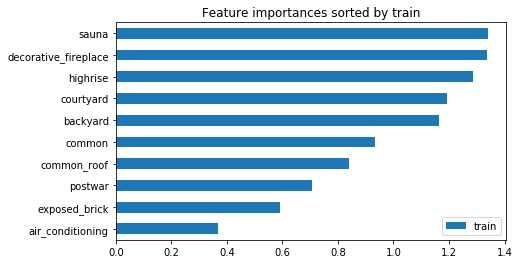

In [21]:
ax=imp.sort_values('train').head(10).plot.barh(title='Feature importances sorted by train', figsize=(7,4))

In [42]:
X_train[featuresInUse][:1]

,bathrooms,bedrooms,latitude,listing_id,longitude,price,street_address,24,_dishwasher_,_dryer,...,num_photos,num_description_words,price_per_bed,price_per_bath,price_per_room,display_street_dist,building_id_mean_medium,building_id_mean_high,manager_id_mean_medium,manager_id_mean_high
0,1.5,3,40.7145,7211212,-73.9425,3000,21630,0,0,0,...,5,95,1000.0,2000.0,666.666667,4,0.217575,0.074369,0.283585,9.190504e-29


In [118]:
param_grid = {'eta':[.05, .1], 'num_round':[1500,2000,2500], 'subsample':[.8], 'colsample_bytree':[.5,.85], \
              'max_depth':[7,8,9], 'seed':[2017]}
for eta in param_grid['eta']:
    for subsample in param_grid['subsample']:
        for colsample_bytree in param_grid['colsample_bytree']:
            for max_depth in param_grid['max_depth']:
                for seed in param_grid['seed']:
                    model=xgbClass(colsample_bytree=colsample_bytree, eta=eta, eva_metric='mlogloss', \
                                       subsample=subsample, max_depth=max_depth, seed=seed,\
                                       objective='multi:softprob', num_class=3)
                    score=CVScore(model=model, my_score=log_loss, X_train=(X_train[featuresInUse])[:1000],\
                                  y_train=y_train[:1000])
                    print('eta={}, subsample={}, colsample_bytree={}, max_depth={}, seed={}, score={}'.\
                          format(eta, subsample, colsample_bytree, max_depth, seed, score))

eta=0.05, subsample=0.8, colsample_bytree=0.5, max_depth=7, seed=2017, score=0.779808339637
eta=0.05, subsample=0.8, colsample_bytree=0.5, max_depth=8, seed=2017, score=0.784862294439
eta=0.05, subsample=0.8, colsample_bytree=0.5, max_depth=9, seed=2017, score=0.773337911985
eta=0.05, subsample=0.8, colsample_bytree=0.85, max_depth=7, seed=2017, score=0.816064663766
eta=0.05, subsample=0.8, colsample_bytree=0.85, max_depth=8, seed=2017, score=0.811353070429
eta=0.05, subsample=0.8, colsample_bytree=0.85, max_depth=9, seed=2017, score=0.810019330864
eta=0.1, subsample=0.8, colsample_bytree=0.5, max_depth=7, seed=2017, score=0.865377438549
eta=0.1, subsample=0.8, colsample_bytree=0.5, max_depth=8, seed=2017, score=0.853401404163
eta=0.1, subsample=0.8, colsample_bytree=0.5, max_depth=9, seed=2017, score=0.849779077778
eta=0.1, subsample=0.8, colsample_bytree=0.85, max_depth=7, seed=2017, score=0.889451200573
eta=0.1, subsample=0.8, colsample_bytree=0.85, max_depth=8, seed=2017, score=0.8

In [ ]:
print("Start fitting...")

# param = {}
# param['objective'] = 'multi:softprob'
# param['eta'] = 0.02
# param['max_depth'] = 4
# param['silent'] = 1
# param['num_class'] = 3
# param['eval_metric'] = "mlogloss"
# param['min_child_weight'] = 1
# param['subsample'] = 0.7
# param['colsample_bytree'] = 0.7
# param['seed'] = 321
# param['nthread'] = 8
# num_rounds = 2000

xgtrain = xgb.DMatrix(X_train[featuresInUse], label=y_train)
clf = xgb.train(param, xgtrain, num_rounds)

print("Fitted")

def prepare_submission(model):
    xgtest = xgb.DMatrix(X_test[featuresInUse])
    preds = model.predict(xgtest)    
    sub = pd.DataFrame(data = {'listing_id': X_test['listing_id'].ravel()})
    sub['low'] = preds[:, 0]
    sub['medium'] = preds[:, 1]
    sub['high'] = preds[:, 2]
    sub.to_csv("It_is_lit2.csv", index = False, header = True)

prepare_submission(clf)

Start fitting...
